# Introduction
This notebook walks through an interactive but basic query of ICESat-2 ATL03 data from NSIDC using [Sliderule](http://icesat2sliderule.org).

__Jonathan Markel__<br />
Graduate Research Assistant <br />
[3D Geospatial Laboratory](https://magruder3dgl.com/icesat-2)<br />
The University of Texas at Austin <br />
jonathanmarkel@gmail.com

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from datetime import datetime
from shapely.geometry import Polygon, Point, mapping
import matplotlib.pyplot as plt
from matplotlib import colors
import pyproj
from sliderule import icesat2
from ipyleaflet import Map, basemaps, DrawControl
from ipyleaflet import Polygon as IPyPolygon
from scipy.optimize import curve_fit
from scipy.stats import exponnorm, norm, skewnorm, expon
from scipy.signal import medfilt, peak_widths, peak_prominences, find_peaks

import ipywidgets as widgets
from tqdm import tqdm
import traceback
import warnings
import logging
plt.set_loglevel("warning")

# Define AOI + Time

Draw the bounding box you would like to download ICESat-2 data for. Ensure that only 1 box is drawn on the map before continuing!

In [6]:
collection = []
def handle_draw(target, action, geo_json):

    new_item = geo_json['geometry']
    # new_item = Polygon(geo_json['geometry']['coordinates'][0])

    if action =='created':
        collection.append(new_item)

        if len(collection) > 1:
            warnings.warn('Only 1 polygon allowed for bounding box. Use delete tool to remove extra boxes and click save before continuing.')

    elif action == 'deleted':
        collection.remove(new_item)


bounding_box = []
m = Map(basemap=basemaps.Esri.WorldImagery, center=(23.951465, -78.121304), zoom=7, scroll_wheel_zoom=True)

dc = DrawControl(circlemarker={}, polyline={}, polygon={}, edit=False) 
# removing edit button until figured out the right way to assign modifications to existing polygons

dc.rectangle = {
    "shapeOptions": {
        "fillColor": "#bf5700",
        "color": "#bf5700",
        "fillOpacity": 0.5
    }
}

dc.polygon = {
    "shapeOptions": {
        "fillColor": "#bf5700",
        "color": "#bf5700",
        "fillOpacity": 0.5
    }
}

dc.on_draw(handle_draw)
m.add_control(dc)

display(m)

start_date = datetime(2018, 10, 15)
end_date = datetime.now()

dates = pd.date_range(start_date, end_date, freq='D')

options = [(date.strftime(' %d %b %Y '), date) for date in dates]
index = (0, len(options)-1)

selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='',
    orientation='horizontal',
    layout={'width': '700px'}
)
print('SELECT TIME RANGE FOR ICESAT2 QUERY')
display(selection_range_slider)

Map(center=[23.951465, -78.121304], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

SELECT TIME RANGE FOR ICESAT2 QUERY


SelectionRangeSlider(index=(0, 1394), layout=Layout(width='700px'), options=((' 15 Oct 2018 ', Timestamp('2018…

# Query IS2 Data

From the SlideRule documentation: "Note, it is often the case that the list of resources (i.e. granules) returned by the CMR system includes granules that come close, but do not actually intersect the region of interest. This is due to geolocation margin added to all CMR ICESat-2 resources in order to account for the spacecraft off-pointing. The consequence is that SlideRule will return no data for some of the resources and issue a warning statement to that effect; this can be ignored and indicates no issue with the data processing."

In [7]:
# sliderule set up
url="icesat2sliderule.org"
icesat2.init(url, verbose=False, loglevel=None)
asset = "nsidc-s3"

if len(collection) > 0:
    bbox = collection[0]['coordinates'][0]
else:
    raise Exception("Please draw a bounding box in the map before continuing.")

# sliderule formatted region from bounding box
sr_reg = icesat2.toregion(gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(np.array(bbox)[:, 0], 
                                np.array(bbox)[:, 1]))
                         )

release = '005'
time_start = selection_range_slider.value[0].strftime('%Y-%m-%dT%H:%M:%SZ')
time_end = selection_range_slider.value[1].strftime('%Y-%m-%dT%H:%M:%SZ')


granules_list = icesat2.cmr(polygon=sr_reg[0], version=release, short_name='ATL03', 
                            time_start=time_start, 
                            time_end=time_end)

print('{} granules returned by CMR'.format(len(granules_list)))
# Compile parameters for subsetting data download
params = {}
params['poly'] = sr_reg[0]
params['srt'] = int('0') # signal confidence surface type (0 land, 1 ocean)
params['cnf'] = 1 # minimum signal confidence


3 granules returned by CMR


In [8]:
gdf = icesat2.atl03sp(params, asset=asset, version=release, resources=granules_list)

# Sort and Select Track(s) to Classify

In [7]:
# must be called after sliderule query completed
import seaborn as sns
import bokeh
from bokeh.tile_providers import get_provider
tile_provider = get_provider('ESRI_IMAGERY')
from bokeh.models import ColumnDataSource, CustomJS, Button, Circle
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.layouts import gridplot, row
output_notebook()

Loading BokehJS ...

In [8]:
# helpful functions for SlideRule's formatted data
def reduce_gdf(gdf, RGT=None, track=None, pair=None, cycle=None):
    '''function from icesat2 hackweek'''
    D3 = gdf.copy()
    
    if RGT is not None:
        D3 = D3[D3["rgt"] == RGT]
    if track is not None:
        D3 = D3[D3["track"] == track]
    if pair is not None:
        D3 = D3[D3["pair"] == pair]
    if cycle is not None:
        D3 = D3[D3["cycle"] == cycle] 
        
    return D3

In [9]:
# can improve this later with interactive selection of plots
# moving on

plot_limit = 3 # max figures to plot before stopping
subsample_count = 1e5 #reduce load by only plotting this many photons

# sliderule has its own format for handling gtxxs (see reduce_gdf())
gts = [10, 11, 20, 21, 30, 31]

# go through each granule, see which ones got data
# if one has data, try each gtxx to see which are there

is2_profiles = []

plot_count = 0

for gran in granules_list:
    gran_plotted = False
    rgt_ = gran[21:25]
    cycle_ = gran[25:27]
    for track_ in [3, 2, 1]:
        for pair_ in [0, 1]:
            if plot_count < plot_limit:

                try:
                    gdf_ = reduce_gdf(gdf, RGT=int(rgt_), cycle=int(cycle_), track=track_, pair=pair_)
                    print(gdf_.shape)
                except:
                    print('unable to reduce dataframe!')
                    continue

                if gdf_.shape[0] > 0:
                    profile_id_str = '{} {} {} {}'.format(rgt_, cycle_, track_, pair_)
                    is2_profiles.append(profile_id_str)
                    
                    plot_count += 1

                    # subsample photon data for quicker plotting
                    gdf__=gdf_.sample(min(int(subsample_count), gdf_.shape[0]))
                    
                    gdf__ = gdf__.loc[gdf__.atl03_cnf >= 0, :]

                    # convert sampled gdf lat lon to web mercator for plotting
                    wgs84 = pyproj.crs.CRS.from_epsg(4979)
                    web_merc = pyproj.crs.CRS.from_epsg(3857)
                    tform = pyproj.transformer.Transformer.from_crs(crs_from=wgs84, crs_to=web_merc)
                    y_wm, x_wm = tform.transform(gdf__.geometry.y, gdf__.geometry.x)

                    fig_map = figure(x_range=(min(y_wm), max(y_wm)), 
                                                    y_range=(min(x_wm)-(max(y_wm)-min(y_wm)) * 0.2, 
                                                                max(x_wm)+(max(y_wm)-min(y_wm)) * 0.2), # zooms out proportionally
                                                    width=420, height=600,
                                                    x_axis_type="mercator", y_axis_type="mercator", tools='zoom_in, zoom_out, wheel_zoom, pan')
                    fig_map.add_tile(tile_provider)
                    fig_map.line(y_wm, x_wm, color='red', line_width=1)                

                    fig = figure(title=profile_id_str + ' (SAMPLE)',
                                                width=840, height=600, x_axis_type="mercator", 
                                                x_range=fig_map.y_range, tools='zoom_in,zoom_out,pan,box_zoom,wheel_zoom, undo, redo')

                    fig.circle(x_wm, gdf__.height, size=0.15, color='black')

                    fig_grid = row([fig_map, fig])
                    show(fig_grid)
                        

                else:
                    print('Reached maximum number of quick view plots set by user. ({})'.format(plot_limit))  
                    break

# select the desired track from the drop down
# use widgets.SelectMultiple later
# make this better...
profiles_to_classify = widgets.Dropdown(
    options=is2_profiles,
    value=is2_profiles[0],
    description='Select:',
    disabled=False, layout={'width': 'max-content'}
)

display(profiles_to_classify)

(0, 15)
(0, 15)
(0, 15)
(0, 15)
(0, 15)
(0, 15)
(1320340, 15)
(1433835, 15)
(1499403, 15)
(1341710, 15)


(1673478, 15)
(1774121, 15)


Dropdown(description='Select:', layout=Layout(width='max-content'), options=('0166 11 3 0', '0166 11 3 1', '01…

In [48]:
# proceding with the track just selected
pc_name = profiles_to_classify.value
gdf1 = reduce_gdf(gdf, 
                  RGT=int(pc_name[:4]), 
                  cycle=int(pc_name[5:7]), 
                  track=int(pc_name[8:9]), 
                  pair=int(pc_name[10:11]))

# convert to orthometric heights - EGM96 for google earth kml
if 'height_ortho' not in gdf1.columns:
    wgs84 = pyproj.crs.CRS.from_epsg(4979)
    wgs84_egm08 = pyproj.crs.CRS.from_epsg(3855)
    # tform = pyproj.transformer.Transformer.from_crs(crs_from=wgs84, crs_to=wgs84_egm08)
    # _, _, z_g = tform.transform(gdf1.geometry.y, gdf1.geometry.x, gdf1.height)
    # gdf1.insert(0, 'height_ortho_08', z_g, False) 
    
    wgs84_egm96 = pyproj.crs.CRS.from_epsg(5773)
    tform = pyproj.transformer.Transformer.from_crs(crs_from=wgs84, crs_to=wgs84_egm96)
    _, _, z_g_96 = tform.transform(gdf1.geometry.y, gdf1.geometry.x, gdf1.height)
    gdf1.insert(0, 'height_ortho_96', z_g_96, False) 
else:
    raise Exception('Orthometric heights already in reduced dataframe')

,along_track,lon,lat,height_ortho_96,segment_dist,sc_orient,rgt,segment_id,cycle,track,distance,quality_ph,atl08_class,delta_time,height,atl03_cnf,yapc_score,pair,geometry
time,,,,,,,,,,,,,,,,,,,
2021-04-04 16:50:29.496718304,2.564457,-123.675339,47.910415,1259.720086,1.473647e+07,1,166,735765,11,2,-21.433670,0,4,1.027902e+08,1240.133911,2,0,1,POINT (-123.67534 47.91042)
2021-04-04 16:50:29.496718304,4.231739,-123.675443,47.910407,1732.303558,1.473647e+07,1,166,735765,11,2,-19.766389,0,4,1.027902e+08,1712.717163,0,0,1,POINT (-123.67544 47.91041)
2021-04-04 16:50:29.496718304,2.610818,-123.675342,47.910415,1272.733764,1.473647e+07,1,166,735765,11,2,-21.387309,0,4,1.027902e+08,1253.147583,0,0,1,POINT (-123.67534 47.91042)
2021-04-04 16:50:29.496718304,2.585063,-123.675340,47.910415,1265.540279,1.473647e+07,1,166,735765,11,2,-21.413065,0,4,1.027902e+08,1245.954102,2,0,1,POINT (-123.67534 47.91042)
2021-04-04 16:50:29.496718304,0.000000,-123.675179,47.910428,532.824788,1.473647e+07,1,166,735765,11,2,-23.998128,0,4,1.027902e+08,513.238953,0,0,1,POINT (-123.67518 47.91043)


Text(0.5, 1.0, 'All photon data for the selected track')

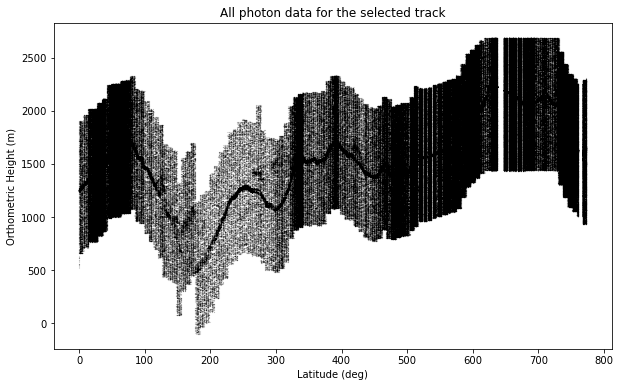

In [50]:
if 'lat' not in gdf1.columns: 
    gdf1.insert(0, 'lat', gdf1.geometry.y, False) 
if 'lon' not in gdf1.columns: 
    gdf1.insert(0, 'lon', gdf1.geometry.x, False)
    
if 'along_track' not in gdf1.columns:
    at_ = gdf1.segment_dist + gdf1.loc[:, 'distance']
    gdf1.insert(0, 'along_track', at_ - min(at_), False)

display(gdf1.head())

plt.figure(figsize=(10,6))
plt.plot(gdf1.segment_id - gdf1.segment_id.min(), gdf1.height_ortho_96, 'k.', alpha=0.5, markersize=0.2)
plt.xlabel('Latitude (deg)')
plt.ylabel('Orthometric Height (m)')
plt.title('All photon data for the selected track')